# Particle tracking with tracer

In [1]:
import numpy as np
from datetime import timedelta as delta, datetime
import xarray as xr
from parcels import FieldSet, Variable, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode
import glob
import matplotlib.pyplot as plt
from calendar import monthrange

%matplotlib inline

#### Parameters

In [2]:
# Sub-domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

#### Load files

In [3]:
# Open particle initialization location file:
ini_loc_PC = xr.open_dataset('/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/western-PC-transect-parcels.nc')
PC_lons    = ini_loc_PC['longitude'].values
PC_lats    = ini_loc_PC['latitude'].values
PC_deps    = ini_loc_PC['depth'].values

# ini_loc_GR = xr.open_dataset('/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Greenland-transect-parcels.nc')
# GR_lons    = ini_loc_GR['longitude'].values
# GR_lats    = ini_loc_GR['latitude'].values
# GR_deps    = ini_loc_GR['depth'].values

ini_loc_DS = xr.open_dataset('/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Greenland-transect2-parcels.nc')
DS_lons    = ini_loc_DS['longitude'].values
DS_lats    = ini_loc_DS['latitude'].values
DS_deps    = ini_loc_DS['depth'].values

In [4]:
# ANHA12 mesh grid:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
# mesh_lon     = mesh['nav_lon'].values
# mesh_lat     = mesh['nav_lat'].values
# mesh_bathy   = mesh['tmask'][0,:,:,:].values
# bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
# ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

#### General setup

Timestamps:

In [5]:
year      = 2014
# Mesh mask
mesh_mask = '/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc'

# Lists of ANHA12 NEMO U,V,W files (on full ANHA12 domain)
folder_ANHA12      = '/data/brogalla/ANHA12/'
ANHA12_gridU_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridU.nc'))   + \
                     sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year+1}m??d??_gridU.nc')) + \
                     sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year+2}m??d??_gridU.nc'))
ANHA12_gridV_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridV.nc'))   + \
                     sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year+1}m??d??_gridV.nc')) + \
                     sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year+2}m??d??_gridV.nc'))
ANHA12_gridW_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_5d_gridW_y{year}m??d??.nc'))  + \
                     sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_5d_gridW_y{year+1}m??d??.nc'))+ \
                     sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_5d_gridW_y{year+2}m??d??.nc'))

# Lists of ANHA12 NEMO Pb tracer files (on sub-domain of full ANHA12 domain)
folder_Pb1 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-{year}_20230308/'
folder_Pb2 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-{year+1}_20230308/'
folder_Pb3 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-{year+2}_20230308/'
files_Pb  = sorted(glob.glob(f'{folder_Pb1}ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_{year}*')) + \
            sorted(glob.glob(f'{folder_Pb2}ANHA12_EXH006_5d_{year+1}0101_{year+1}1231_ptrc_T_{year+1}*')) + \
            sorted(glob.glob(f'{folder_Pb3}ANHA12_EXH006_5d_{year+2}0101_{year+2}1231_ptrc_T_{year+2}*'))

# Create timestamps from file dates: (because of time_origin issue in ANHA12 netcdf dynamics files)
time_stamps_files = []
for n, file in enumerate(ANHA12_gridU_files):
    dateU  = datetime.strptime(file[36:47],'y%Ym%md%d')
    dateV  = datetime.strptime(ANHA12_gridV_files[n][36:47],'y%Ym%md%d')
    dateW  = datetime.strptime(ANHA12_gridW_files[n][45:56],'y%Ym%md%d')
    datePb = datetime.strptime(files_Pb[n][125:133],'%Y%m%d')
#     datePb = dateW
    # print(dateU, dateV, dateW, datePb)
    
    # double-check that the date is the same for all files
    if (dateU != dateV) | (dateU != dateW) | (dateU != datePb):
        print('Dates not equal!')
    else:   
        time_stamps_files.append(np.datetime64(f'{dateU.year:02}-{dateU.month:02}-{dateU.day:02}'))

# array of file timestamps
timestamps_files = np.expand_dims(np.array(time_stamps_files), axis=1)

Run with Pb as tracer (Pb on sub-domain, U,V,W on full domain)

In [6]:
filenames  = {'U': {'lon': mesh_mask     , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridU_files},
              'V': {'lon': mesh_mask     , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridV_files},
              'W': {'lon': mesh_mask     , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridW_files},
              'Pb': {'lon': files_Pb[0]  , 'lat': files_Pb[0], 'depth': files_Pb[0], 'data': files_Pb}}

dimensions = {'U':  {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'V':  {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'W':  {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'Pb': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'deptht'}}

variables  = {'U': 'vozocrtx',
              'V': 'vomecrty',
              'W': 'vovecrtz',
              'Pb': 'dissolpb'}

# needed to provide time as timestamps in order to avoid time origin type issue
fieldset   = FieldSet.from_nemo(filenames, variables, dimensions, \
                                timestamps=timestamps_files, \
                                allow_time_extrapolation=False)

#### General functions

In [7]:
def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

In [8]:
# define new particle class for Pb
class PbParticle(JITParticle): 
    dissolvedPb = Variable('dissolpb', initial=0)  # Variable 'dissolpb' initialised by sampling the dissolved Pb field

In [9]:
def SamplePb(particle, fieldset, time):
    particle.dissolpb = fieldset.Pb[particle.time, particle.depth, particle.lat, particle.lon]

In [12]:
def pushback(particle, fieldset, time):
    particle.depth = 1.0

In [13]:
def run_parcels(fieldset, plon, plat, pdepth, ptime, runtime=0, sampling=False, filename='test.zarr'):

    # Define particle locations on a grid in my domain:
    pset = ParticleSet(fieldset=fieldset, pclass=PbParticle, lon=plon, lat=plat, depth=pdepth, time=ptime)#, 
                       # repeatdt=delta(hours=24*7).total_seconds()) # release every four weeks

    output_file = pset.ParticleFile(name=f"/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/{filename}", 
                                    outputdt=delta(hours=16))

    # Nudge the particle set locations closer to the actual grid locations:               
    for i in range(len(pset)):
        for gi, g in enumerate(fieldset.gridset.grids):
            d = np.hypot((pset.lon[i] - g.lon), (pset.lat[i] - g.lat))
            ind = np.unravel_index(np.argmin(d, axis=None), d.shape)
            pset.xi[i, gi] = ind[1]
            pset.yi[i, gi] = ind[0]
    
    # Option to run with tracer sampling kernel (SamplePb) or only with 3D advection kernel
    if sampling:
        pset.execute(AdvectionRK4_3D + pset.Kernel(SamplePb), 
                     runtime = runtime, dt = delta(hours=8), 
                     output_file = output_file,
                     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                               ErrorCode.ErrorThroughSurface: pushback})        
    else:
        pset.execute(AdvectionRK4_3D, runtime=runtime, dt=delta(hours=8),  
                     output_file = output_file,
                     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle,
                               ErrorCode.ErrorThroughSurface: pushback})
    
    return pset

#### Run:

In [14]:
release_days = np.append(0, np.cumsum([monthrange(2014, i)[1] for i in range(1,6)]))
release_time = np.array([delta(hours=24*float(i)).total_seconds() for i in release_days])

In [15]:
PC_lat   = np.linspace(74.5, 76, 10)
PC_lon   = np.ones(PC_lat.shape)*-123 
PC_depth = depths[0:30]
PC_time  = release_time

# Release each parcel at a particular lon, lat, and depth, and time:
PC_lats   = np.tile(np.repeat(PC_lat, len(PC_depth)), len(PC_time))
PC_lons   = np.tile(np.repeat(PC_lon, len(PC_depth)), len(PC_time))
PC_depths = np.tile(np.tile(PC_depth, len(PC_lat)), len(PC_time))
PC_times  = np.repeat(PC_time, len(PC_lat)*len(PC_depth))

In [16]:
# plon   = np.concatenate((PC_lons, DS_lons))
# plat   = np.concatenate((PC_lats, DS_lats))
# pdepth = np.concatenate((PC_deps, DS_deps))
plon   = PC_lons
plat   = PC_lats
pdepth = PC_depths
ptime  = PC_times

In [ ]:
pset = run_parcels(fieldset, plon, plat, pdepth, ptime, runtime=delta(hours=24*365*2.5), 
                   sampling=True, filename='20230326_runtime2yrs_release2014monthly.zarr') 

INFO: Compiled ArrayPbParticleAdvectionRK4_3DSamplePb ==> /tmp/parcels-2672/lib2f0b64aa784ef33fe03e44de9a98812b_0.so
INFO: Output files are stored in /ocean/brogalla/GEOTRACES/parcels/Pb-chapter/20230326_runtime2yrs_release2014monthly.zarr.
 14%|████████████████████                                                                                                                        | 11289600.0/78840000.0 [17:10<2:23:20, 7853.95it/s]

In [16]:
pset = run_parcels(fieldset, plon, plat, pdepth, ptime, runtime=delta(hours=24*365*2.5), 
                   sampling=True, filename='20230326_runtime2yrs_release2014monthly.zarr') 

INFO: Compiled ArrayPbParticleAdvectionRK4_3DSamplePb ==> /tmp/parcels-2672/lib6559e38758256f719d5bbd87d4a7d13c_0.so
INFO: Output files are stored in /ocean/brogalla/GEOTRACES/parcels/Pb-chapter/20230326_runtime2yrs_release2014monthly.zarr.
 18%|█████████████████████████                                                                                                                   | 11289600.0/63072000.0 [17:10<1:47:53, 7998.74it/s]

KeyboardInterrupt: 

In [ ]:
def load_tracks(filename, tracer='dissolpb'):
    file  = xr.open_zarr(filename)
    traj  = file['trajectory'].values # dimensions: number of particles, tracks
    time  = file['time'].values       # units: seconds
    lat   = file['lat'].values        # degrees North
    lon   = file['lon'].values        # degrees East
    depth = file['z'].values          # meters
    trace = file[tracer].values       # tracer concentration
    
    return traj, time, lon, lat, depth, trace

In [82]:
# Load results: 
traj_t1, time_t1, lon_t1, lat_t1, depth_t1, dPb_t1 = \
    load_tracks(f'/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/test1.zarr', tracer='dissolpb')

(54.0, 87.0)

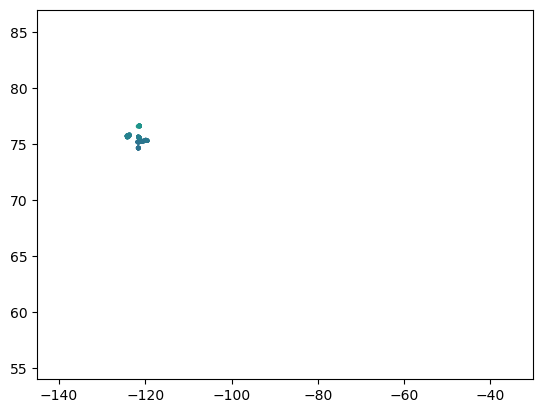

In [77]:
plt.scatter(pset.lon, pset.lat, s=5, c=pset.dissolpb, vmin=0, vmax=10e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)